https://www.cnblogs.com/hellcat/p/7182541.html

## Part1 RNN

#### Train <br>
把 ground-truth word 当做 RNN 的输入，也有把这种做法叫做 teacher forcing 的 <br>
比较常见的做法<br>
#### Inference/test <br> 
把 RNN 上时刻的输出，当做下时刻的输入 <br>
比如训练的时候也这样做，就会比较难训练 <br>

**单个RNN神经元**

In [ ]:
# 前向
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    next_h, cache = None, None
    next_h = np.tanh(x.dot(Wx) + prev_h.dot(Wh) + b)  #  # 其实使用y = x.dot(w) + b 效果是一样的，自动广播到最低维度
# prev_h: Hidden state from previous timestep, of shape (N, H)
# Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
# Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    cache = (x, Wx, Wh, prev_h, next_h)
    return next_h, cache

#后向
def rnn_step_backward(dnext_h, cache):
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    x, Wx, Wh, prev_h, next_h = cache
    dtanh = 1 - next_h**2
    dx = (dnext_h*dtanh).dot(Wx.T)
    dWx = x.T.dot(dnext_h*dtanh)
    dprev_h = (dnext_h*dtanh).dot(Wh.T)
    dWh = prev_h.T.dot(dnext_h*dtanh)
    db = np.sum(dnext_h*dtanh,axis=0)
    return dx, dprev_h, dWx, dWh, db

**推导：**
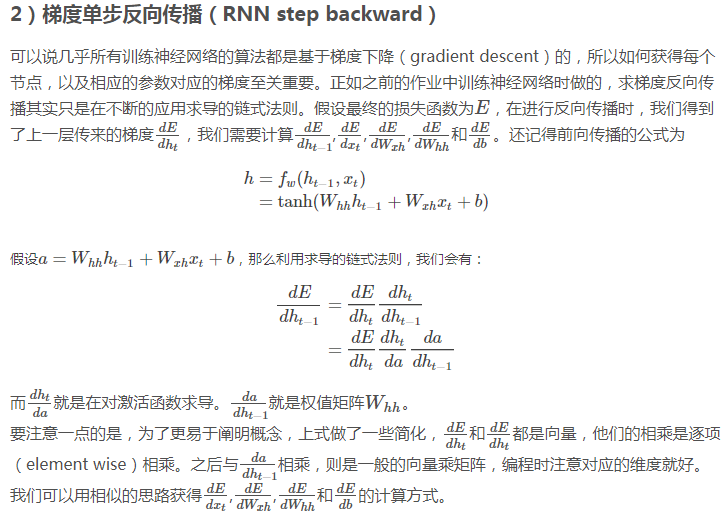

**单层RNN神经元**

In [ ]:
#前向
def rnn_forward(x, h0, Wx, Wh, b):
#h0: Initial hidden state, of shape (N, H)
#Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
#Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    h, cache = None, None
    N, T, D = x.shape
    _, H = h0.shape
    h = np.zeros((N,T,H))
    h_next = h0
    cache = []
    for i in range(T):
        h[:,i,:], cache_next = rnn_step_forward(x[:,i,:], h_next, Wx, Wh, b)
        h_next = h[:,i,:]
        cache.append(cache_next)
    return h, cache
#反向
def rnn_backward(dh, cache):
#dh0: Gradient of initial hidden state, of shape (N, H)
#dWx: Gradient of input-to-hidden weights, of shape (D, H)
#dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    x, Wx, Wh, prev_h, next_h = cache[-1]
    _, D = x.shape
    N, T, H = dh.shape
    dx = np.zeros((N,T,D))
    dh0 = np.zeros((N,H))
    dWx = np.zeros((D,H))
    dWh = np.zeros((H,H))
    db = np.zeros(H)
    dprev_h_ = np.zeros((N,H))
    for i in range(T-1,-1,-1):
        dx_, dprev_h_, dWx_, dWh_, db_ = rnn_step_backward(dh[:,i,:] + dprev_h_, cache.pop())
        dx[:,i,:] = dx_
        dh0 = dprev_h_
        dWx += dWx_
        dWh += dWh_
        db += db_
    return dx, dh0, dWx, dWh, db


# 方法二：
def affine_forward(x, w, b):
    out = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    x, w, b = cache
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    return dx, dw, db

**字符和向量的映射**

In [ ]:
def word_embedding_forward(x, W):
    out = W[x, :]
    cache = (W, x)
    return out, cache

def word_embedding_backward(dout, cache):
    W, x = cache
    dW = np.zeros_like(W)
    np.add.at(dW, x, dout)
   
    return dW

**np.add.at**

In [ ]:
Examples

Increment items 0 and 1, and increment item 2 twice:

>>> a = np.array([1, 2, 3, 4])
>>> np.add.at(a, [0, 1, 2, 2], 1)
>>> print(a)
array([2, 3, 5, 4])
Add items 0 and 1 in first array to second array, and store results in first array:

>>> a = np.array([1, 2, 3, 4])
>>> b = np.array([1, 2])
>>> np.add.at(a, [0, 1], b)
>>> print(a)
array([2, 4, 3, 4])

## Part2 LSTM

LSTM是RNN的增强版，1.RNN能完成的工作LSTM也都能胜任且有更好的效果；2.LSTM解决了RNN梯度消失或爆炸的问题，进而可以具有比RNN更为长时的记忆能力。

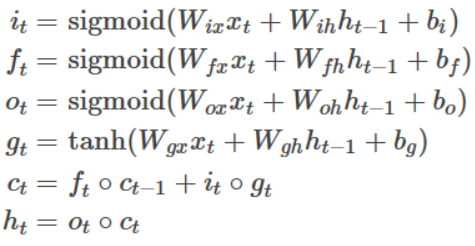

In [ ]:
#向前传播
#单个LSTM神经元向前传播

def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    next_h, next_c, cache = None, None, None
    _, H = prev_h.shape
    a = x.dot(Wx) + prev_h.dot(Wh) + b
    i,f,o,g = sigmoid(a[:,:H]),sigmoid(a[:,H:2*H]),sigmoid(a[:,2*H:3*H]),np.tanh(a[:,3*H:])
    next_c = f*prev_c + i*g
    next_h = o*np.tanh(next_c)
    cache = [i, f, o, g, x, prev_h, prev_c, Wx, Wh, b, next_c]
    return next_h, next_c, cache

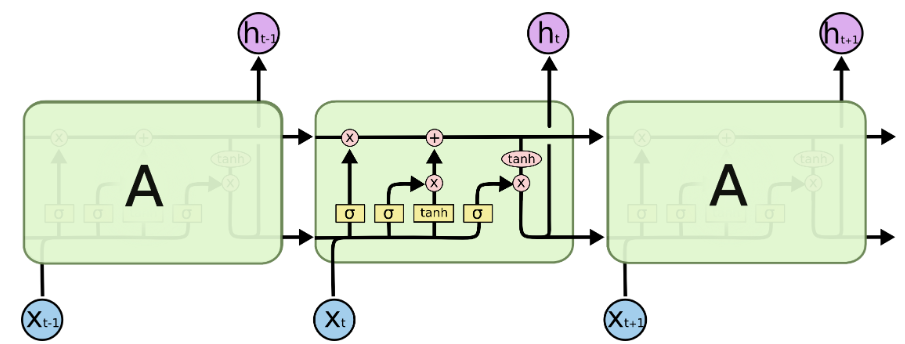

**层LSTM神经元向前传播**

In [ ]:
def lstm_forward(x, h0, Wx, Wh, b):
#assume an input sequence composed of T vectors, each of dimension D.
    h, cache = None, None
    N,T,D = x.shape
    next_c = np.zeros_like(h0)
    next_h = h0
    h, cache = [], []
    for i in range(T):
        next_h, next_c, cache_step = lstm_step_forward(x[:,i,:], next_h, next_c, Wx, Wh, b)
        h.append(next_h)
        cache.append(cache_step)
    h = np.array(h).transpose(1,0,2) #<-----------注意分析h存储后的维度是(T,N,H)，需要转置为(N，T，H)
    return h, cache

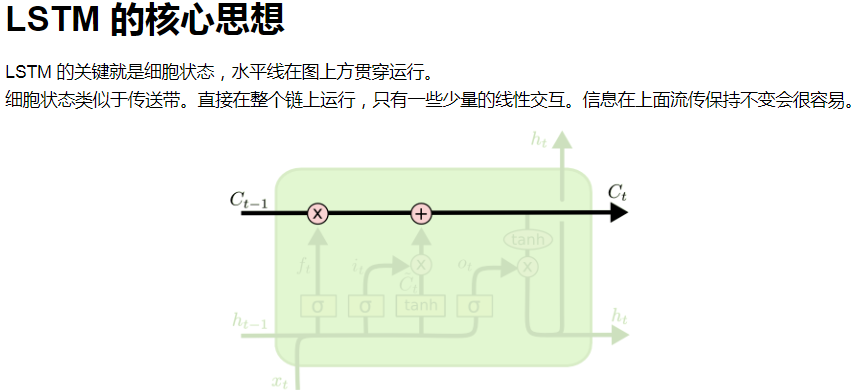

## 反向传播
**注意实际反向传播时，初始的C梯度是自己初始化的，而h梯度继承自高层（分类或者h到词袋的转化层，h层和RNN实际相同）**

**单个LSTM神经元反向传播**

In [ ]:
def lstm_step_backward(dnext_h, dnext_c, cache):
    i, f, o, g, x, prev_h, prev_c, Wx, Wh, b, next_c = cache
   
    do = dnext_h*np.tanh(next_c)
    dnext_c += dnext_h*o*(1-np.tanh(next_c)**2) #<-----------上面分析行为有提到这里的求法
   
    di, df, dg, dprev_c = (g, prev_c, i, f) * dnext_c
    da = np.concatenate([i*(1-i)*di, f*(1-f)*df, o*(1-o)*do, (1-g**2)*dg],axis=1)
  
    db = np.sum(da,axis=0)
    dx, dWx, dprev_h, dWh = (da.dot(Wx.T), x.T.dot(da), da.dot(Wh.T), prev_h.T.dot(da))
 
    return dx, dprev_h, dprev_c, dWx, dWh, db

**推导：**
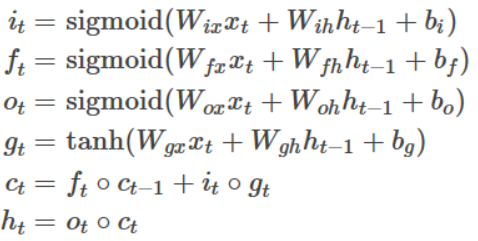

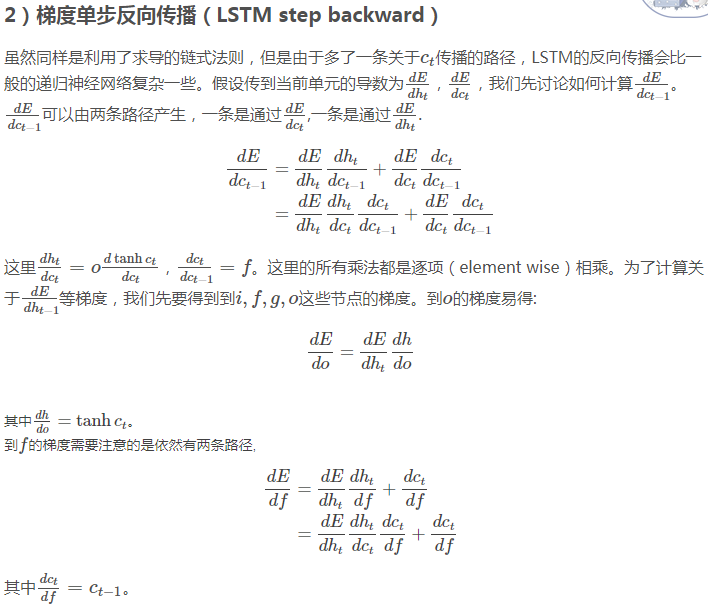

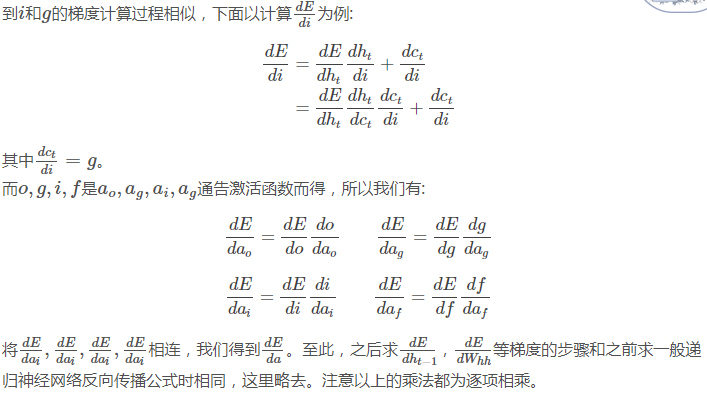

**层LSTM神经元反向传播**

In [ ]:
def lstm_backward(dh, cache):
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    N,T,H = dh.shape
    _, D = cache[0][4].shape
    dx, dh0, dWx, dWh, db = [], np.zeros((N, H), dtype='float32'), np.zeros((D, 4*H), dtype='float32'),\
        np.zeros((H, 4*H), dtype='float32'), np.zeros(4*H, dtype='float32')
        
    step_dprev_h, step_dprev_c = np.zeros((N,H)),np.zeros((N,H))
    for i in xrange(T-1, -1, -1):
        step_dx, step_dprev_h, step_dprev_c, step_dWx, step_dWh, step_db = \
             lstm_step_backward(dh[:,i,:] + step_dprev_h, step_dprev_c, cache[i])
        dx.append(step_dx) # 每一个输入节点都有自己的梯度
        dWx += step_dWx    # 层共享参数，需要累加和
        dWh += step_dWh    # 层共享参数，需要累加和
        db += step_db      # 层共享参数，需要累加和
    dh0 = step_dprev_h   # 只有最初输入的h0，即feature的投影（图像标注中），需要存储梯度
    dx = np.array(dx[::-1]).transpose((1,0,2))
   
    return dx, dh0, dWx, dWh, db

### 图像注释生成
整体架构是，图像特征对应于初始隐藏状态，在训练时真实的图片注释为每一时刻的输入，输出序列为RNN/LSTM对图片注释序列的预测。

In [ ]:
    def loss(self, features, captions):
        """
        计算训练时RNN/LSTM的损失函数。我们输入图像特征和正确的图片注释，使用RNN/LSTM计算损失函数和所有参数的梯度
        输入:
        - features: 输入图像特征，维度 (N, D)
        - captions: 正确的图像注释; 维度为(N, T)的整数列

        输出一个tuple：
        - loss: 标量损失函数值
        - grads: 所有参数的梯度
        """

        """
        这里将captions分成了两个部分，captions_in是除了最后一个词外的所有词，是输入到RNN/LSTM的输入；captions_out是除了第一个词外的所有词，是RNN/LSTM期望得到的输出。
        """
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # 之后会用到
        mask = (captions_out != self._null)

        # 从图像特征到初始隐藏状态的权值矩阵和偏差值 
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

        # 词嵌入矩阵
        W_embed = self.params['W_embed']

        # RNN/LSTM参数
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # 每一隐藏层到输出的权值矩阵和偏差
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        N,D=features.shape

        # 用线性变换从图像特征值得到初始隐藏状态，将产生维度为(N,H)的数列 
        out, cache_affine = temporal_affine_forward(features.reshape(N,1,D), W_proj, b_proj)
        N,t,H=out.shape
        h0=out.reshape(N,H)

        # 用词嵌入层将captions_in中词的索引转换成词响亮，得到一个维度为(N, T, W)的数列
        word_out,cache_word=word_embedding_forward(captions_in, W_embed)

        # 用RNN/LSTM处理输入的词向量，产生每一层的隐藏状态,维度为(N,T,H),这里演示的是LSTM的
        # RNN forward
        # hidden, cache_hidden = rnn_forward(word_out, h0, Wx, Wh, b)
        # LSTM forward
        hidden, cache_hidden = lstm_forward(word_out, h0, Wx, Wh, b)


        # 用线性变换计算每一步隐藏层对应的输出(得分)，维度(N, T, V)
        out_vo, cache_vo = temporal_affine_forward(hidden, W_vocab, b_vocab)

        # 用softmax函数计算损失，真实值为captions_out, 用mask忽视所有向量中<NULL>词汇
        loss, dx = temporal_softmax_loss(out_vo[:,:,:],captions_out, mask, verbose=False)

        #之后再逐步计算反向传播，得到对应的参数
        dx_affine,dW_vocab,db_vocab=temporal_affine_backward(dx, cache_vo)
        grads['W_vocab']=dW_vocab
        grads['b_vocab']=db_vocab

        # RNN backward
        # dx_hidden, dh0, dWx, dWh, db = rnn_backward(dx_affine, cache_hidden)
        # LSTM bascward
        dx_hidden, dh0, dWx, dWh, db = lstm_backward(dx_affine, cache_hidden)

        grads['Wx']=dWx
        grads['Wh']=dWh
        grads['b']=db

        dW_embed = word_embedding_backward(dx_hidden, cache_word)
        grads['W_embed']=dW_embed

        dx_initial,dW_proj,db_proj=temporal_affine_backward(dh0.reshape(N,t,H), cache_affine)
        grads['W_proj']=dW_proj
        grads['b_proj']=db_proj

        return loss, grads

### 图片注释采样

In [ ]:
    def sample(self, features, max_length=30):
        """
        和上一段代码不同的地方是，这里我们没有了真实的图像注释。所以每一时刻的输入这样获得：计算隐藏层对应的输出，这些输出表示所有词汇表中词汇的得分，取得分最高的词汇，作为下一时刻的输入。其他与上一节里的代码相同。因为不能同时获得所有输入，我们必须循环应用RNN/LSTM step forward。
        对于LSTM，还需记录单元c的状态，初始值为0

        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.
        输入:
        - captions: 输入图像特征，维度 (N, D)
        - max_length: 生成的注释的最长长度
        输出:
        - captions: 采样得到的注释，维度(N, max_length), 每个元素是词汇的索引
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # 参数
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        N,D=features.shape

        # 用线性变换从图像特征值得到初始隐藏状态，将产生维度为(N,H)的数列 
        out, cache_affine = temporal_affine_forward(features.reshape(N,1,D), W_proj, b_proj)
        N,t,H=out.shape
        h0=out.reshape(N,H)
        h=h0
        # 初始输入
        x0=W_embed[[1,1],:]
        x_input=x0
        captions[:,0]=[1,1]
        # prev_c only for lstm
        prev_c=np.zeros_like(h)
        for i in range(0,max_length-1):
            # RNN step forward
            # next_h, _ = rnn_step_forward(x_input, h, Wx, Wh, b)

            # LSTM step forward
            next_h, next_c, cache = lstm_step_forward(x_input, h, prev_c, Wx, Wh, b)
            # only for lstm
            prev_c=next_c
            #计算每一层输出
            out_vo, cache_vo = temporal_affine_forward(next_h.reshape(N,1,H), W_vocab, b_vocab)
            #找到输出最大值的项作为下一时刻的输入
            index=np.argmax(out_vo,axis=2)
            x_input=np.squeeze(W_embed[index,:])
            h=next_h
            #记录其索引
            captions[:,i+1]=np.squeeze(index)

        return captions


## **Attention机制：**<br>
优化-RNN中图像信息只在初始化有用的情况。

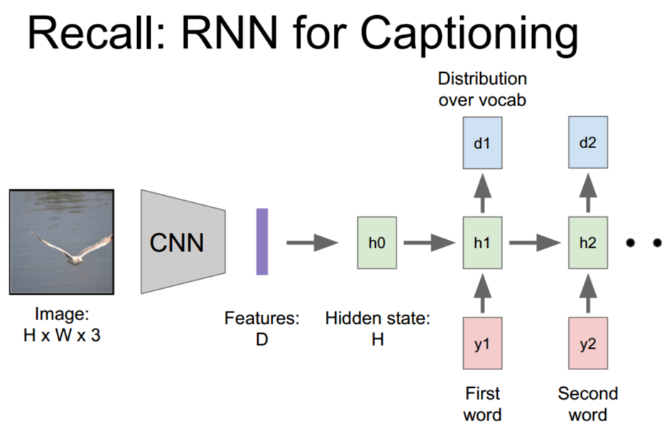

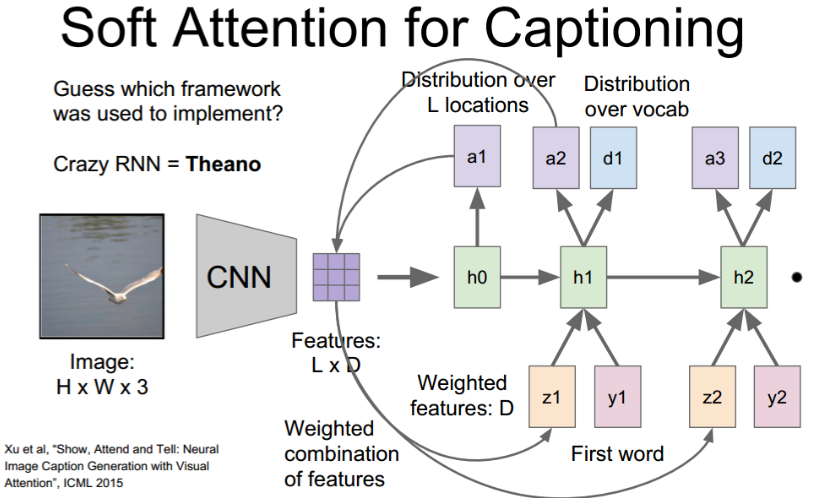

每一层具有三个输入：隐藏状态 + 注意力特征向量 + 词向量<br>
<br>
每一层具有两个输出：新的位置分布（指示下一次‘观测’位置） + 词向量概率分布<br>

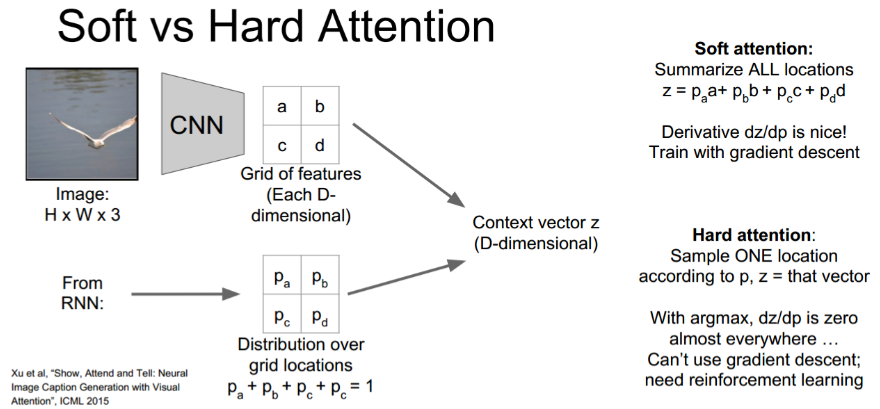

**空间转化器：弥补Soft模式关注区受限制的问题**<br>
<br>
**关注位置裁剪可学习化：**<br>
裁剪操作是不可微的，但是可以通过参数使得这一过程连续，即建立坐标映射，这样就可以将关注位置到输入图像这一过程可学习化，整合入网络

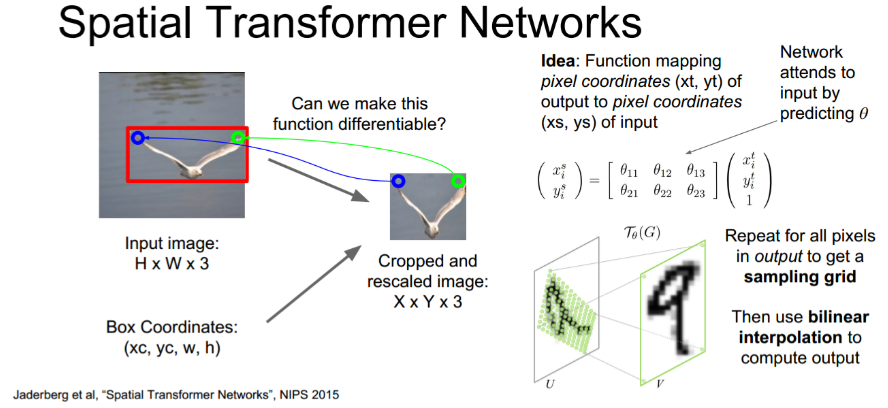

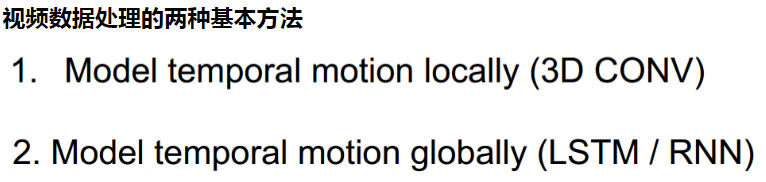

https://www.cnblogs.com/hellcat/p/7349615.html#_label2<br>
- 使用3D卷积网络引入时间维度：由于3D卷积网络每次的输入帧是有长度限定的，所以这种方法更倾向于关注局部（时域）信息的任务<br>
<br>
- 使用RNN/LSTM网络系列处理时序信息：由于迭代网络的特性，它更擅长处理全局视频信息<br>

对于CNNs，有一个通用的设计规则就是：在后面的层（离输出层近的）特征map的个数应该增加，这样就可以从低级的特征maps组合产生更多类型的特征。<br>
<br>
传统的2D卷积方法是用一个2维的卷积层对特征图进行采样，从而得到下一层的特征图，形式如下：<br>
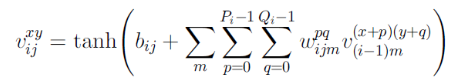
<br>



那么3D就是额外增加了一个时间维度，即对一定数量帧的图片，用同一个3维的卷积层去采样，从而得到下一维的特征图，形式如下：<br>
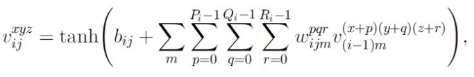
<br>
多出来的那个Ri，即是3维卷积核在时间维度上的长度。


**3D卷积神经网络架构**
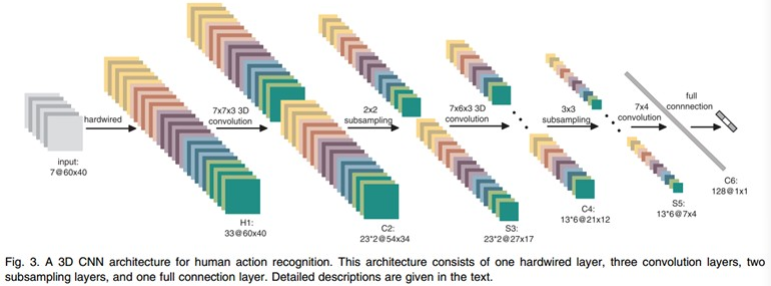
    -文中的3D CNN架构包含一个硬连线hardwired层、3个卷积层、2个下采样层和一个全连接层。每个3D卷积核卷积的立方体是连续7帧，每帧patch大小是60x40，架构如上<br>
    在第一层，我们应用了一个固定的hardwired的核去对原始的帧进行处理，产生多个通道的信息，然后对多个通道分别处理。最后再将所有通道的信息组合起来得到最终的特征描述。这个实线层实际上是编码了我们对特征的先验知识

# 无监督学习

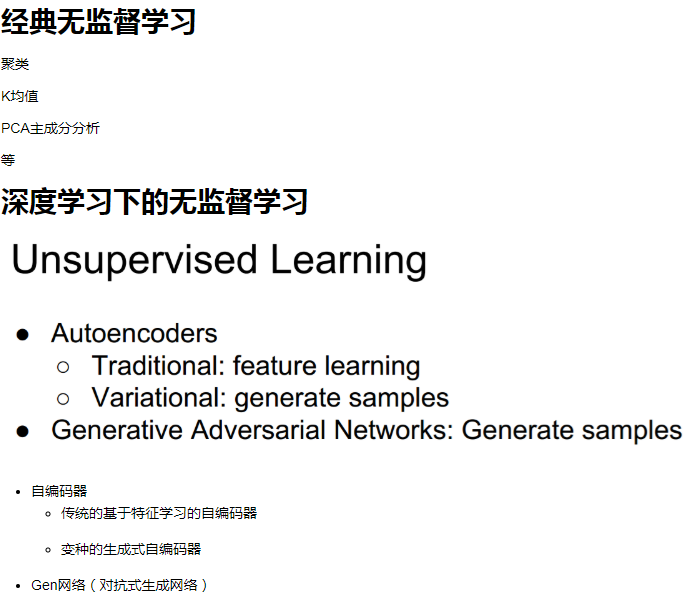

## 对抗式生成网络

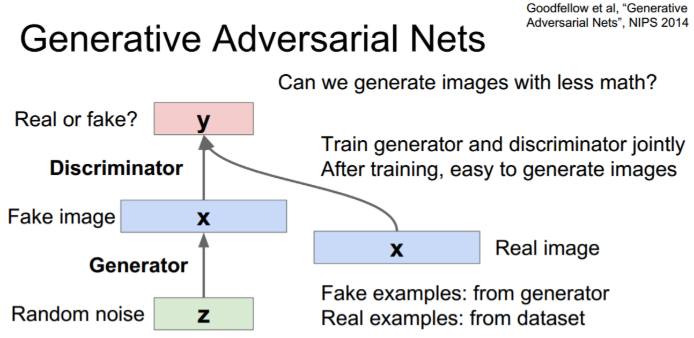